# Homework 7 - Part 1: LASSO Regression
## BIOST 558 Spring 2020
### Juan Solorio

In [1]:
# needed libraries

# vizualization
import matplotlib.pyplot as plt

# data wrangling and math
import pandas as pd
import numpy as np

# machine learing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model


%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Load the data
hitters = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv',
                      sep=',', header=0)
hitters = hitters.dropna()
X = hitters.drop('Salary', axis=1) 
X = pd.get_dummies(X, drop_first=True) 
y = hitters.Salary

def standarize_data(X,y):
    """
    Function to train test split and standarize the data
    """
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    xmean = np.mean(x_train, axis=0)
    xsdev = np.std(x_train, axis=0)
    ymean = np.mean(y_train, axis=0)
    ysdev = np.std(y_train, axis=0)
    x_train = (x_train - xmean)/xsdev[np.newaxis, :]
    x_test = (x_test - xmean)/xsdev[np.newaxis, :]
    y_train= (y_train - ymean)/ysdev
    y_test = (y_test - ymean)/ysdev
    
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

x_train, y_train, x_test, y_test = standarize_data(X=X, y=y)

### LASSO
#### Theory

For LASSO regression, we have the $l_1$-regularized least-square regression defined as:

\begin{equation}
\min_{\beta}F(\beta) = \frac{1}{2n}\sum_{i=1}^n(y_i - x^T_i\beta)^2 + \lambda\|\beta\|_1
\end{equation}

assuming we have $n=d=1$, the sum then becomes

\begin{equation}
F(\beta) = \frac{1}{2}(y - x\beta)^2 + \lambda|\beta|
\end{equation}

We can then take the derivative of $F(\beta)$ with respect to $\beta$ and solve the equation:

\begin{equation}
\frac{dF}{d\beta} = -x(y - x\beta) + \lambda \\
\Rightarrow x^2\beta + \lambda - yx = 0 \\
\Rightarrow \beta = \frac{xy-\lambda}{x^2}
\end{equation}

From the derivative we get the piece wise function for $\beta$:

$$ \beta(c)=   \left\{
\begin{array}{ll}
      c+\lambda & if\ \ c < -\lambda \\
      c-\lambda & if\ \ c > +\lambda \\
      0 & if\ \ |c| \leq \lambda
\end{array} 
\right.  $$



$$ \beta(c)=   \left\{
\begin{array}{ll}
      \frac{c+\lambda}{a} & if\ \ c < -\lambda \\
      \frac{c-\lambda}{a} & if\ \ c > +\lambda \\
      0 & if\ \ |c| \leq \lambda
\end{array} 
\right.  $$

In [3]:
def beta_stepwise(xy, lamda):
    if xy < -lamda:
        numerator = xy + lamda
    elif xy > lamda:
        numerator = xy - lamda
    else:
        numerator = 0
    return numerator

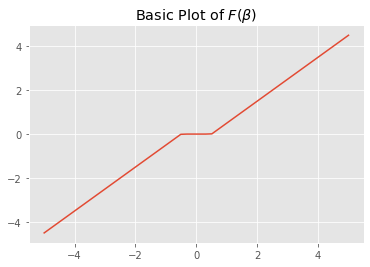

In [6]:
xplot = np.linspace(-5,5,50)
lamda = 0.5
y_Fx = [beta_stepwise(xi,lamda) for xi in xplot ]
plt.plot(xplot, y_Fx)
plt.title(r'Basic Plot of $F(\beta)$')
plt.show()

We can then take this basic derivation for $n=d=1$ and implement it for $n>1\ ,\ d>1$. In Matrix Notation, we can take the gradient of $F(\beta)$ with respect to $\beta$ as follows:
\begin{equation}
F(\beta) = (Y - X\beta)^T(Y-X\beta) + \lambda\beta
\end{equation}
\begin{equation}
= Y^TY - \beta^TX^TY-Y^TX\beta+\beta^TX^TX\beta+\lambda\beta
\end{equation}
\begin{equation}
= Y^TY - 2\beta^TX^TY+\beta^TX^TX\beta+\lambda\beta \\
\end{equation}
\begin{equation}
\nabla_\beta F(\beta)= -X^TY + X^TX\beta + \lambda \\
\Rightarrow \beta = \frac{X^TY - \lambda}{X^TX}
\end{equation}

From here, we can take the previous piece wise function for $\beta$ and expand to define $c$ and $a$ as:
$$ \beta(c_j)=   \left\{
\begin{array}{ll}
      \frac{c_j+\lambda}{a_j} & if\ \ c_j < -\lambda \\
      \frac{c_j-\lambda}{a_j} & if\ \ c_j > +\lambda \\
      0 & if\ \ |c_j| \leq \lambda
\end{array} 
\right.  $$

\begin{equation}
a_j = \sum_{i=1}^nx^2_{i,j} \ \  \ \ \ \ c_j=\sum_{i=1}^nx_{i,j}(y_i-x^T_{i,-j}\beta_j) 
\end{equation}

In [7]:
def Fx_min_beta(b, j, X, y, lamda):
    n, d = X.shape
    j_i = [i for i in range(d) if i != j ]
    
    c_j = X[:, j] @ (y[:, np.newaxis] - X[:, j_i] @ b[:, np.newaxis][j_i, :])
    a_j = np.linalg.norm(X[:,j])**2
    
    r = beta_stepwise(xy=c_j, lamda=lamda*n/2)
    
    return r/a_j

In [8]:
def computeobj(b, lamda, X, y):
    
    n, d = X.shape
    penalty = lamda*np.linalg.norm(b)
    
    return (1/(2*n)) * np.sum((y - (X @ b))**2) - penalty
    

In [9]:
def cycliccoorddescet(beta_init, X, y, lamda, max_iter):
    n, d = X.shape
    beta = beta_init
    beta_vals = beta
    for i in range(max_iter):
        for j in range(d):
            beta_j = Fx_min_beta(b=beta, j=j, X=X, y=y, lamda=lamda)
            beta[j] = beta_j
        beta_vals = np.vstack((beta_vals, beta))
    return beta_vals

In [10]:
def pickcoord(d, j):
    num = np.random.randint(0,d)
    while num == j:
        num = np.random.randint(0,d)
    return num

In [11]:
def randcoorddescent(beta_init, X, y, lamda, max_iter):
    n, d = X.shape
    beta = np.copy(beta_init)
    beta_vals = beta
    for i in range(max_iter):
        j = 1
        for k in range(d):
            j = pickcoord(d, j)
            beta_j = Fx_min_beta(b=beta, j=j, X=X, y=y, lamda=lamda)
            beta[j] = beta_j
        beta_vals = np.vstack((beta_vals, beta))
    return beta_vals

In [12]:
def compute_correct_zero_nonzero(b_own, b_skl, non_zero=False):
    num_iter = len(b_skl)
    own = 0
    skl = 0
    for n in range(num_iter):
        if non_zero == False:
            if b_skl[n] == 0:
                skl += 1
                if b_own[n] == 0:
                    own += 1
        else:
            if b_skl[n] != 0:
                skl += 1
                if b_own[n] != 0:
                    own += 1
                        
    return own/skl

In [18]:
n, d = x_train.shape
betas_init = np.zeros(d)
lasso_cv = linear_model.LassoCV(cv=10, random_state=0,fit_intercept=False,max_iter=1000)
lasso_cv.fit(x_train, y_train)

optimal_lambda = 2*lasso_cv.alpha_
beta_skl = lasso_cv.coef_


betas_cyclic = cycliccoorddescet(beta_init=betas_init, X=x_train, y=y_train, lamda=optimal_lambda, max_iter=1000)
betas_random = randcoorddescent(beta_init=betas_init, X=x_train, y=y_train, lamda=optimal_lambda, max_iter=1000)


In [19]:
betas_cyclic[-1], betas_random[-1], beta_skl

(array([-0.40178734,  0.44817461,  0.09057008,  0.        ,  0.01092209,
         0.24231362, -0.06912608,  0.        ,  0.38853311,  0.        ,
         0.35260131,  0.        , -0.29704019,  0.13550563,  0.04299316,
        -0.05854589,  0.0261108 , -0.12125553,  0.        ]),
 array([-0.40178734,  0.44817461,  0.09057008,  0.        ,  0.01092209,
         0.24231362, -0.06912608,  0.        ,  0.38853311,  0.        ,
         0.35260131,  0.        , -0.29704019,  0.13550563,  0.04299316,
        -0.05854589,  0.0261108 , -0.12125553,  0.        ]),
 array([-0.40151056,  0.44792634,  0.09077503, -0.        ,  0.01070252,
         0.24238375, -0.06950319, -0.        ,  0.39076738, -0.        ,
         0.35045337,  0.        , -0.29676259,  0.13544564,  0.04297573,
        -0.05859965,  0.0260473 , -0.12133111,  0.        ]))

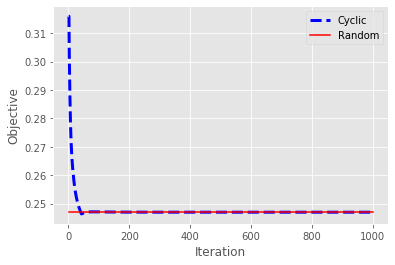

In [20]:
n_b, d_b = betas_cyclic.shape

obj_cyclic = np.zeros(n_b)
obj_random = np.zeros(n_b)

for i in range(n_b):
    obj_cyclic[i] = computeobj(b=betas_cyclic[i], lamda=optimal_lambda,X=x_train, y=y_train)
    obj_random[i] = computeobj(b=betas_random[i], lamda=optimal_lambda, X=x_train, y=y_train)
    
fig, ax = plt.subplots()
ax.plot(range(1, n_b + 1), obj_cyclic, c='blue', label='Cyclic', linewidth=3.0, linestyle='dashed')
ax.plot(range(1, n_b + 1), obj_random, c='red', label='Random')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.legend()
plt.show()

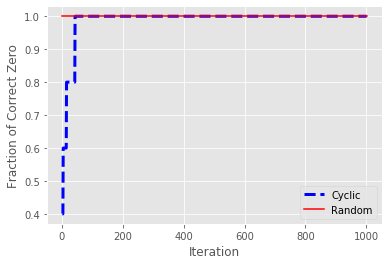

In [16]:
cyclic_zero = np.zeros(n_b)
random_zero = np.zeros(n_b)

for i in range(n_b):
    cyclic_zero[i] = compute_correct_zero_nonzero(b_own=betas_cyclic[i],b_skl=beta_skl,non_zero=False)
    random_zero[i] = compute_correct_zero_nonzero(b_own=betas_random[i],b_skl=beta_skl,non_zero=False)
    
    
fig, ax = plt.subplots()
ax.plot(range(1, n_b + 1), cyclic_zero, c='blue', label='Cyclic', linewidth=3.0, linestyle='dashed')
ax.plot(range(1, n_b + 1), random_zero, c='red', label='Random')
plt.xlabel('Iteration')
plt.ylabel('Fraction of Correct Zero')
plt.legend()
plt.show()

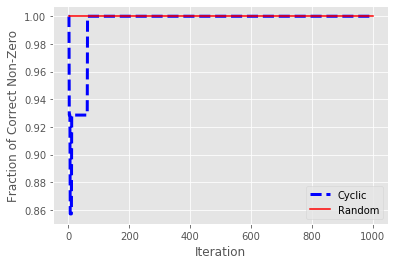

In [17]:
cyclic_nonzero = np.zeros(n_b)
random_nonzero = np.zeros(n_b)
for i in range(n_b):
    cyclic_nonzero[i] = compute_correct_zero_nonzero(b_own=betas_cyclic[i,:],b_skl=beta_skl,non_zero=True)
    random_nonzero[i] = compute_correct_zero_nonzero(b_own=betas_random[i,:],b_skl=beta_skl,non_zero=True)
    
fig, ax = plt.subplots()
ax.plot(range(1, n_b + 1), cyclic_nonzero, c='blue', label='Cyclic', linewidth=3.0, linestyle='dashed')
ax.plot(range(1, n_b + 1), random_nonzero, c='red', label='Random')
plt.xlabel('Iteration')
plt.ylabel('Fraction of Correct Non-Zero')
plt.legend()
plt.show()